In [1]:
import pandas as pd
import numpy as np
import os
import re

import sys

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from shapely.ops import split
from shapely.affinity import translate

import pickle
import folium
import fiona

%matplotlib inline

# Описание задачи

Задача предсказания цен на квартиры в Москве - задача регрессии

Она может быть важна для агентств недвижимости, инвесторов, застройщиков и других участников рынка недвижимости. На основе предсказаний цен можно делать более точные прогнозы доходности инвестиций, планировать стратегии продаж и закупки объектов недвижимости, а также определять ценообразование на рынке.

# Описание данных:

- author - автор объявления

- author_type - тип автора (real_estate_agent - агентство недвижимости, homeowner - собственник, realtor - риелтор, official_representative - ук оф.представитель, representative_developer - представитель застройщика, developer - застройщик, unknown - без указанного типа)

- link - ссылка на объявление

- city - город, в котором находится квартира

- deal_type - тип объявления, к примеру, долгосрочная, краткосрочная аренда, продажа ("rent_long", "rent_short", "sale")

- accommodation_type - вид жилья, к примеру, квартира, комната, дом, часть дома, таунхаус ("flat", "room", "house", "house-part", "townhouse")

- floor - этаж, на котором находится квартира

- floors_count - общее количество этажей в доме

- rooms_count - количество комнат в квартире

- total_meters - общая площадь

- price_per_m2 - стоимость на квадратный метр

- **price - стоимость квартиры (целевая переменная)**

- district - район, в котором находится квартира

- street - улица

- underground - метро

- residential_complex - название жилого комплекса

- line - ветка, на которой находится метро

- area - округ, в котором находится квартира

- eco_rating - экологический рейтинг района, в котром находится квартира

- insufficient_infrastructure - недостаточно инфраструктуры, %

- convenient_for_life - удобность для жизни, %

- very_convenient_for_life - очень комфортный для жизни, %

- few_entertainment - недостаточно мест для досуга и развлечений, %

- cultural - оценка культурных мест, %

- entertainment - оценка развлекательных мест, %

- cultural_entertainment - оценка культурно-развлекательных мест, %

- residential_infrastructure_rating - рейтинг жилой инфраструктуры 

- entertainment_infrastructure_rating - рейтинг развлекательной инфраструктуры 

- square - площадь района

- population - численность населения в районе

- housing_fund_area - площадь жилфонда

- line_count - количество пересадочных станций

- author_count - количество объявлений у автора

- author_more - флаг, который показывает что у автора больше двух объявлений

- floor_position - позиция этажа (2 - последний этаж, 1 -первый этаж, 0 - середина)

- house_category - категория дома в зависимости от количества этажей (1 - малоэтажные (1 - 2 этажа), 2 - средней этажности (3 - 5 этажей), 3 - многоэтажные (6-10), 4 - повышенной этажности (11 - 16 этажей), 5 - высотные (16-50 этажей), 6 - очень высотные (более 50 этажей))
- population_density - плотность населения района

In [2]:
path = 'data/true'

all_csv_data = []

for filename in os.listdir(path):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(path, filename), sep=';')
        all_csv_data.append(df)

cian = pd.concat(all_csv_data, axis=0, ignore_index=True)

In [3]:
cian[:5]

author                                      link    city  \
0    Sminex-Интеко  https://www.cian.ru/sale/flat/281914898/  Москва   
1         MR Group  https://www.cian.ru/sale/flat/285682464/  Москва   
2           GloraX  https://www.cian.ru/sale/flat/277738124/  Москва   
3  ANT Development  https://www.cian.ru/sale/flat/283856161/  Москва   
4    Sminex-Интеко  https://www.cian.ru/sale/flat/281051002/  Москва   

  deal_type accommodation_type  floor  floors_count  rooms_count  \
0      sale               flat      3             5            2   
1      sale               flat      3            10            2   
2      sale               flat      5            21            2   
3      sale               flat     27            32            2   
4      sale               flat      6            14            2   

   total_meters      price      district            street        underground  \
0         67.07  149930000      Тверской               NaN  Площадь Революции   
1         62.70   34485000       Беговой       Северный ао        Белорусская   
2         77.85   34069999       Беговой  1-я Ямского Поля        Белорусская   
3         50.90   40703799  Дорогомилово         Поклонная        Парк Победы   
4         85.60  187560000      Якиманка               NaN            Полянка   

           residential_complex author_type  price_per_m2  
0               Ильинка 3/8 ЖК         NaN           NaN  
1                     Слава ЖК         NaN           NaN  
2  Глоракс Премиум Белорусская         NaN           NaN  
3                  Поклонная 9         NaN           NaN  
4              Лаврушинский ЖК         NaN           NaN

In [4]:
cian.drop_duplicates()

author  \
0                                   Sminex-Интеко   
1                                        MR Group   
2                                          GloraX   
3                                 ANT Development   
4                                   Sminex-Интеко   
...                                           ...   
15407                                 МОСКВА СИТИ   
15409                                    Звездный   
15410                                         ФСК   
15412  МИЦ-Столичный ипотечный центр недвижимости   
15413                                 ID 18872712   

                                           link    city deal_type  \
0      https://www.cian.ru/sale/flat/281914898/  Москва      sale   
1      https://www.cian.ru/sale/flat/285682464/  Москва      sale   
2      https://www.cian.ru/sale/flat/277738124/  Москва      sale   
3      https://www.cian.ru/sale/flat/283856161/  Москва      sale   
4      https://www.cian.ru/sale/flat/281051002/  Москва      sale   
...                                         ...     ...       ...   
15407  https://www.cian.ru/sale/flat/281554357/  Москва      sale   
15409  https://www.cian.ru/sale/flat/265307186/  Москва      sale   
15410  https://www.cian.ru/sale/flat/280374511/  Москва      sale   
15412  https://www.cian.ru/sale/flat/282034711/  Москва      sale   
15413  https://www.cian.ru/sale/flat/285387023/  Москва      sale   

      accommodation_type  floor  floors_count  rooms_count  total_meters  \
0                   flat      3             5            2         67.07   
1                   flat      3            10            2         62.70   
2                   flat      5            21            2         77.85   
3                   flat     27            32            2         50.90   
4                   flat      6            14            2         85.60   
...                  ...    ...           ...          ...           ...   
15407               flat     17            35            1         45.00   
15409               flat      7            22            1         48.60   
15410               flat      3            29            1         46.30   
15412               flat     11            28            2         45.00   
15413               flat      5            37            1         30.20   

           price            district                   street  \
0      149930000            Тверской                      NaN   
1       34485000             Беговой              Северный ао   
2       34069999             Беговой         1-я Ямского Поля   
3       40703799        Дорогомилово                Поклонная   
4      187560000            Якиманка                      NaN   
...          ...                 ...                      ...   
15407   17200000         Пресненский        Шмитовский проезд   
15409   20380425        Останкинский            проспект Мира   
15410   18201456  Нагатино-Садовники                      NaN   
15412   15349000         Даниловский  набережная Марка Шагала   
15413   14500000             Раменки           Мосфильмовская   

             underground          residential_complex        author_type  \
0      Площадь Революции               Ильинка 3/8 ЖК                NaN   
1            Белорусская                     Слава ЖК                NaN   
2            Белорусская  Глоракс Премиум Белорусская                NaN   
3            Парк Победы                  Поклонная 9                NaN   
4                Полянка              Лаврушинский ЖК                NaN   
...                  ...                          ...                ...   
15407           Шелепиха                    Headliner  real_estate_agent   
15409               ВДНХ                      Сенатор          developer   
15410        Нагатинская                 Роттердам ЖК          developer   
15412           Тульская                       Shagal  real_estate_agent   
15413        Аминьевская                       

In [5]:
underground_line = pd.read_csv('data/underground.csv',
                               sep=';',
                               encoding='cp1251')

In [6]:
underground_line[:5]

object_category_Id   ID               Station                       Line  \
0  object_category_Id  Код  Наименование станции         Наименование линии   
1                 NaN  136         Третьяковская          Калининская линия   
2                 NaN   86            Медведково     Калужско-Рижская линия   
3                 NaN   41          Первомайская  Арбатско-Покровская линия   
4                 NaN  104             Калужская     Калужско-Рижская линия   

                                   AdmArea                   District  \
0                   Административный округ                      Район   
1       Центральный административный округ        район Замоскворечье   
2  Северо-Восточный административный округ  район Северное Медведково   
3         Восточный административный округ            район Измайлово   
4      Юго-Западный административный округ          Обручевский район   

    MCDStation    AeroexpressStation  \
0  Станция МЦД  Станция Аэроэкспресс   
1           []                    []   
2           []                    []   
3           []                    []   
4           []                    []   

                                     RailwayStation  \
0  Станция радиального железнодорожного направления   
1                                                []   
2                                                []   
3                                                []   
4                                                []   

                    RailwayTerminal  ...  Station_en  Line_en  AdmArea_en  \
0  Выход к железнодорожному вокзалу  ...  Station_en  Line_en  AdmArea_en   
1                               NaN  ...         NaN      NaN         NaN   
2                               NaN  ...         NaN      NaN         NaN   
3                               NaN  ...         NaN      NaN         NaN   
4                               NaN  ...         NaN      NaN         NaN   

   District_en  MCDStation_en  AeroexpressStation_en  RailwayStation_en  \
0  District_en  MCDStation_en  AeroexpressStation_en  RailwayStation_en   
1          NaN            NaN                    NaN                NaN   
2          NaN            NaN                    NaN                NaN   
3          NaN            NaN                    NaN                NaN   
4          NaN            NaN                    NaN                NaN   

   RailwayTerminal_en  ObjectStatus_en Unnamed: 23  
0  RailwayTerminal_en  ObjectStatus_en         NaN  
1                 NaN              NaN         NaN  
2                 NaN              NaN         NaN  
3                 NaN              NaN         NaN  
4                 NaN              NaN         NaN  

[5 rows x 24 columns]

In [7]:
underground_line.Line.nunique()

17

In [8]:
cian = cian.merge(underground_line[['Station', 'Line']],
                  left_on='underground',
                  right_on='Station',
                  how='left').drop_duplicates()

In [9]:
cian = cian.rename(columns={"Line":"line"})

In [10]:
geo = pd.read_csv('data/Moscow_Population_2018.csv')

In [11]:
cian.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16209 entries, 0 to 18873
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               16006 non-null  object 
 1   link                 16209 non-null  object 
 2   city                 16209 non-null  object 
 3   deal_type            16209 non-null  object 
 4   accommodation_type   16209 non-null  object 
 5   floor                16209 non-null  int64  
 6   floors_count         16209 non-null  int64  
 7   rooms_count          16209 non-null  int64  
 8   total_meters         16209 non-null  float64
 9   price                16209 non-null  int64  
 10  district             14872 non-null  object 
 11  street               13367 non-null  object 
 12  underground          15894 non-null  object 
 13  residential_complex  10690 non-null  object 
 14  author_type          11679 non-null  object 
 15  price_per_m2         11814 non-null 

In [12]:
geo_gpd = gpd.read_file('data/geo_msc.geojson')

In [13]:
geo_gpd[:5]

district                                           geometry
0  Академический  POLYGON ((55.68403 37.55226, 55.68408 37.55232...
1   Алексеевский  POLYGON ((55.79714 37.63499, 55.79965 37.63552...
2   Алтуфьевский  POLYGON ((55.88730 37.56740, 55.88724 37.57245...
3          Арбат  POLYGON ((55.75202 37.57206, 55.75256 37.57396...
4       Аэропорт  POLYGON ((55.80608 37.51101, 55.80647 37.51137...

In [14]:
eco = pd.read_csv('data/eco.csv')

In [15]:
eco[:5]

district area  eco_rating
0  Косино-Ухтомский  ВАО           7
1    Преображенское  ВАО           7
2    Соколиная Гора  ВАО           9
3       Богородское  ВАО           6
4           Вешняки  ВАО           5


Присоеденим дополнтельные таблицы с признаками к основной таблице

In [16]:
cian = cian.merge(eco, left_on='district', right_on='district',
                  how='left').drop_duplicates()

In [17]:
rating = pd.read_csv('data/raiting_yandex.csv', encoding='cp1251', sep='\t')

In [18]:
cian = cian.merge(rating, left_on='district', right_on='district',
                  how='left').drop_duplicates()

In [19]:
cian = cian.merge(geo[['Район', 'Площадь', 'Население', 'Площадь жилфонда']],
                  left_on='district',
                  right_on='Район',
                  how='left').drop_duplicates()

In [20]:
cian = cian.rename(
    columns={
        "Площадь": "square",
        "Население": "population",
        "Площадь жилфонда": "housing_fund_area"
    })

In [21]:
cian.describe()

floor  floors_count   rooms_count  total_meters         price  \
count  16209.000000  16209.000000  16209.000000  16209.000000  1.620900e+04   
mean      10.279166     19.923869      2.357703     92.594729  6.228970e+07   
std       10.640471     15.272149      1.579305     73.242592  1.102208e+08   
min       -1.000000     -1.000000     -1.000000     -1.000000  2.450000e+06   
25%        3.000000      9.000000      1.000000     39.600000  1.200000e+07   
50%        7.000000     17.000000      2.000000     68.300000  2.698300e+07   
75%       14.000000     26.000000      4.000000    125.900000  7.000000e+07   
max       92.000000     97.000000      5.000000    941.700000  2.107580e+09   

       price_per_m2    eco_rating  insufficient_infrastructure  \
count  1.181400e+04  12793.000000                  12752.00000   
mean   5.452859e+05      5.517470                     18.11708   
std    1.647526e+06      1.530755                     16.04137   
min   -5.890000e+06      2.000000                      0.00000   
25%    2.916660e+05      4.000000                      6.00000   
50%    4.052815e+05      6.000000                     14.00000   
75%    6.148895e+05      6.000000                     26.00000   
max    1.700000e+08      9.000000                    100.00000   

       convenient_for_life  very_convenient_for_life  few_entertainment  \
count         12752.000000              12752.000000       12752.000000   
mean             45.101945                 36.780976          34.352102   
std              24.110202                 28.572864          34.466979   
min               0.000000                  0.000000           0.000000   
25%              27.000000                 10.000000           0.000000   
50%              44.000000                 37.000000          16.000000   
75%              64.000000                 56.000000          70.000000   
max             100.000000                100.000000         100.000000   

           cultural  entertainment  cultural_entertainment  \
count  12752.000000   12752.000000            12752.000000   
mean       3.553874      21.945499               40.148526   
std        7.742792      20.269731               38.993351   
min        0.000000       0.000000                0.000000   
25%        0.000000       5.000000                0.000000   
50%        0.000000      18.000000               31.000000   
75%        6.000000      30.000000               77.000000   
max       69.000000      94.000000              100.000000   

       top_residential_infrastructure  top_entertainment_infrastructure  \
count                    12752.000000                      12752.000000   
mean                        53.394213                         44.901270   
std                         37.193153                         39.732087   
min                          1.000000                          1.000000   
25%                         16.000000                          8.000000   
50%                         49.000000                         23.000000   
75%                         90.000000                         90.000000   
max                        118.000000                        118.000000   

       residential_infrastructure_rating  entertainment_infrastructure_rating  \
count                       12752.000000                         12752.000000   
mean                           74.842613                            61.728592   
std                            16.428257                            34.482276   
min                             0.000000                             0.000000   
25%                            64.000000                            26.000000   
50%                            79.000000                            76.000000   
75%                            86.000000                            97.000000   
max                           100.000000                           100.000000   

          population  
count   12811.000000  
mean    99958.331512

In [22]:
cian.describe(include='object')

author                                      link    city deal_type  \
count   16006                                     16209   16209     16209   
unique   1647                                     11660       1         1   
top       ПИК  https://www.cian.ru/sale/flat/285091945/  Москва      sale   
freq     1282                                        12   16209     16209   

       accommodation_type     district                  street underground  \
count               16209        14872                   13367       15894   
unique                  1          128                    1253         287   
top                  flat  Пресненский  Ленинградский проспект    Шелепиха   
freq                16209         1301                     290         556   

       residential_complex        author_type   Station  \
count                10690              11679     14485   
unique                 754                  7       236   
top         Сердце Столицы  real_estate_agent  Шелепиха   
freq                   264               6242       556   

                           line   area        Район square housing_fund_area  
count                     14485  12793        12811  12811             12811  
unique                       16     10          111    109               111  
top     Большая кольцевая линия    ЦАО  Пресненский   11,7            1416,4  
freq                       1664   4491         1301   1301              1301

Добавим количество веток, к которым относится данная станция метро

In [23]:
cian['line_count'] = cian['link'].map(cian['link'].value_counts())

In [24]:
cian['author_count'] = cian['author'].map(cian['author'].value_counts())

In [25]:
def get_floor_position(data: pd.Series)-> int: 
    """
    Определяет позицию этажа
    0 - среднии этажи
    1 - первый этаж 
    2 - последний этаж
    """
    if data['floor'] == 1:
        return 1
    elif data['floor'] == data['floors_count']:
        return 2
    else:
        return 0

In [26]:
cian['floor_position'] = cian.apply(lambda x: get_floor_position(x), axis=1)

In [27]:
cian.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16209 entries, 0 to 16208
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   author                               16006 non-null  object 
 1   link                                 16209 non-null  object 
 2   city                                 16209 non-null  object 
 3   deal_type                            16209 non-null  object 
 4   accommodation_type                   16209 non-null  object 
 5   floor                                16209 non-null  int64  
 6   floors_count                         16209 non-null  int64  
 7   rooms_count                          16209 non-null  int64  
 8   total_meters                         16209 non-null  float64
 9   price                                16209 non-null  int64  
 10  district                             14872 non-null  object 
 11  street                      

Создадим признак, который указывает что у автора в продаже несколько квартир (больше двух)

In [28]:
cian['author_more'] = cian['author_count'].apply(lambda x: 1 if x > 2 else 0)

In [29]:
def get_house_category(data: pd.Series)-> int: 
    """
    Эта функция подразделяет дома а категории в зависимости от количества этажей.
    По этажности жилые дома подразделяют на:
    - малоэтажные (1 - 2 этажа)
    - средней этажности (3 - 5 этажей)
    - многоэтажные (6-10)
    - повышенной этажности (11 - 16 этажей)
    - высотные (16-50 этажей)
    - очень высотные (более 50 этажей)
    """

    if data <= 2:
        return 1
    elif data > 2 and data <= 5:
        return 2
    elif data > 5 and data <= 10:
        return 3
    elif data > 10 and data <= 16:
        return 4
    elif data > 16 and data <= 50:
        return 5
    elif data > 50:
        return 6

In [30]:
cian['house_category'] = cian['floors_count'].apply(
    lambda x: get_house_category(x))

Так как мы смотрим **квартиры** в **Москве для покупки**, то можем удалить следующие столбцы

In [31]:
cian = cian.drop(
    ['city', 'deal_type', 'accommodation_type', 'Station', 'Район'], axis=1)

In [32]:
cian = cian.drop_duplicates(subset=['link', 'price'])

In [33]:
cian.shape

(12159, 35)

In [34]:
cian.isna().sum()

author                                  133
link                                      0
floor                                     0
floors_count                              0
rooms_count                               0
total_meters                              0
price                                     0
district                               1272
street                                 2405
underground                             295
residential_complex                    4502
author_type                            3563
price_per_m2                           3483
line                                   1633
area                                   2900
eco_rating                             2900
insufficient_infrastructure            2939
convenient_for_life                    2939
very_convenient_for_life               2939
few_entertainment                      2939
cultural                               2939
entertainment                          2939
cultural_entertainment          

In [35]:
lst_col = ['square', 'housing_fund_area']
for i in lst_col:
    cian[i] = cian[i].fillna('-1')
    cian[i] = cian[i].apply(lambda x: x.replace(',', '.'))
    cian[i] = cian[i].astype('float32')

In [36]:
col = [
    'insufficient_infrastructure', 'convenient_for_life',
    'very_convenient_for_life', 'few_entertainment', 'cultural',
    'entertainment', 'cultural_entertainment',
    'top_residential_infrastructure', 'top_entertainment_infrastructure',
    'residential_infrastructure_rating', 'entertainment_infrastructure_rating',
    'eco_rating', 'population', 'floor', 'floors_count', 'rooms_count',
    'author_count'
]

for i in col:
    cian[i] = cian[i].fillna(-1)
    cian[i] = cian[i].astype('int32')

In [37]:
object_cols = cian.select_dtypes(include='object').columns

for i in object_cols:
    if cian[i].isnull().any():
        cian[i].fillna('None', inplace=True)
    cian[i] = cian[i].astype('category')

In [38]:
counts = cian['district'].value_counts()

for index, value in counts.items():
    if value == 1:
        cian['district'].replace({index: 'None'}, inplace=True)

In [39]:
cian['population_density'] = cian.apply(
    lambda x: round(x['population']/x['square'], 2), axis=1)

In [40]:
from scipy.stats import chi2_contingency

table = pd.crosstab(df['district'], df['underground'])

# Расчитываем коэффициент Хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(table)

print(f"Chi-square value: {chi2:.2f}, p-value: {p_value:.2f}")

Chi-square value: 540.00, p-value: 0.00


Убираем столбцы, у которых корреляция больше 0.9

In [41]:
cor_matrix = cian.drop(['housing_fund_area'], axis=1).corr().abs()
upper_tri = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
# Ищем столбцы, где корреляция больше 0.9
to_drop = [
    column for column in upper_tri.columns if any(upper_tri[column] > 0.9)
]
cian = cian.drop(to_drop, axis=1)

C:\Users\rodio\AppData\Local\Temp\ipykernel_13852\1058256231.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))


In [42]:
cian.columns

Index(['author', 'link', 'floor', 'floors_count', 'rooms_count',
       'total_meters', 'price', 'district', 'street', 'underground',
       'residential_complex', 'author_type', 'price_per_m2', 'line', 'area',
       'eco_rating', 'insufficient_infrastructure', 'convenient_for_life',
       'very_convenient_for_life', 'few_entertainment', 'cultural',
       'entertainment', 'cultural_entertainment',
       'residential_infrastructure_rating',
       'entertainment_infrastructure_rating', 'square', 'population',
       'housing_fund_area', 'line_count', 'author_count', 'floor_position',
       'author_more', 'house_category', 'population_density'],
      dtype='object')

In [43]:
cian.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12159 entries, 0 to 16208
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   author                               12159 non-null  category
 1   link                                 12159 non-null  category
 2   floor                                12159 non-null  int32   
 3   floors_count                         12159 non-null  int32   
 4   rooms_count                          12159 non-null  int32   
 5   total_meters                         12159 non-null  float64 
 6   price                                12159 non-null  int64   
 7   district                             12159 non-null  category
 8   street                               12159 non-null  category
 9   underground                          12159 non-null  category
 10  residential_complex                  12159 non-null  category
 11  author_type    

Добавляем в таблицу с координатами столбцы, по которым будем строить карту

In [44]:
geo_gpd = geo_gpd.merge(cian.groupby('district')['link'].count().reset_index(),
                        on='district',
                        how='left')

In [45]:
geo_gpd = geo_gpd.merge(cian.groupby('district')['price'].mean().reset_index(),
                        on='district',
                        how='left')

In [46]:
geo_gpd = geo_gpd.merge(cian[['residential_infrastructure_rating',
                              'eco_rating', 'population',
                              'entertainment_infrastructure_rating',
                              'district',
                              'housing_fund_area',
                              'population_density',
                              'very_convenient_for_life',
                              'convenient_for_life']], on='district', how='left')

In [47]:
def widen_plot(ax, x_scale_factor, y_scale_factor):
    """
    Корректирует ширину и высоту графика
    """
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    new_xmin = xmin - (x_scale_factor - 1) * (xmax - xmin) / 2
    new_xmax = xmax + (x_scale_factor - 1) * (xmax - xmin) / 2
    new_ymin = ymin - (y_scale_factor - 1) * (ymax - ymin) / 2
    new_ymax = ymax + (y_scale_factor - 1) * (ymax - ymin) / 2
    
    ax.set_xlim(new_xmin, new_xmax)
    ax.set_ylim(new_ymin, new_ymax)


In [48]:
district_rooms_count = cian.groupby(
    ['district', 'rooms_count']).agg({'rooms_count': 'count'})
district_rooms_count = district_rooms_count.rename(
    columns={'rooms_count': 'count'}).reset_index()

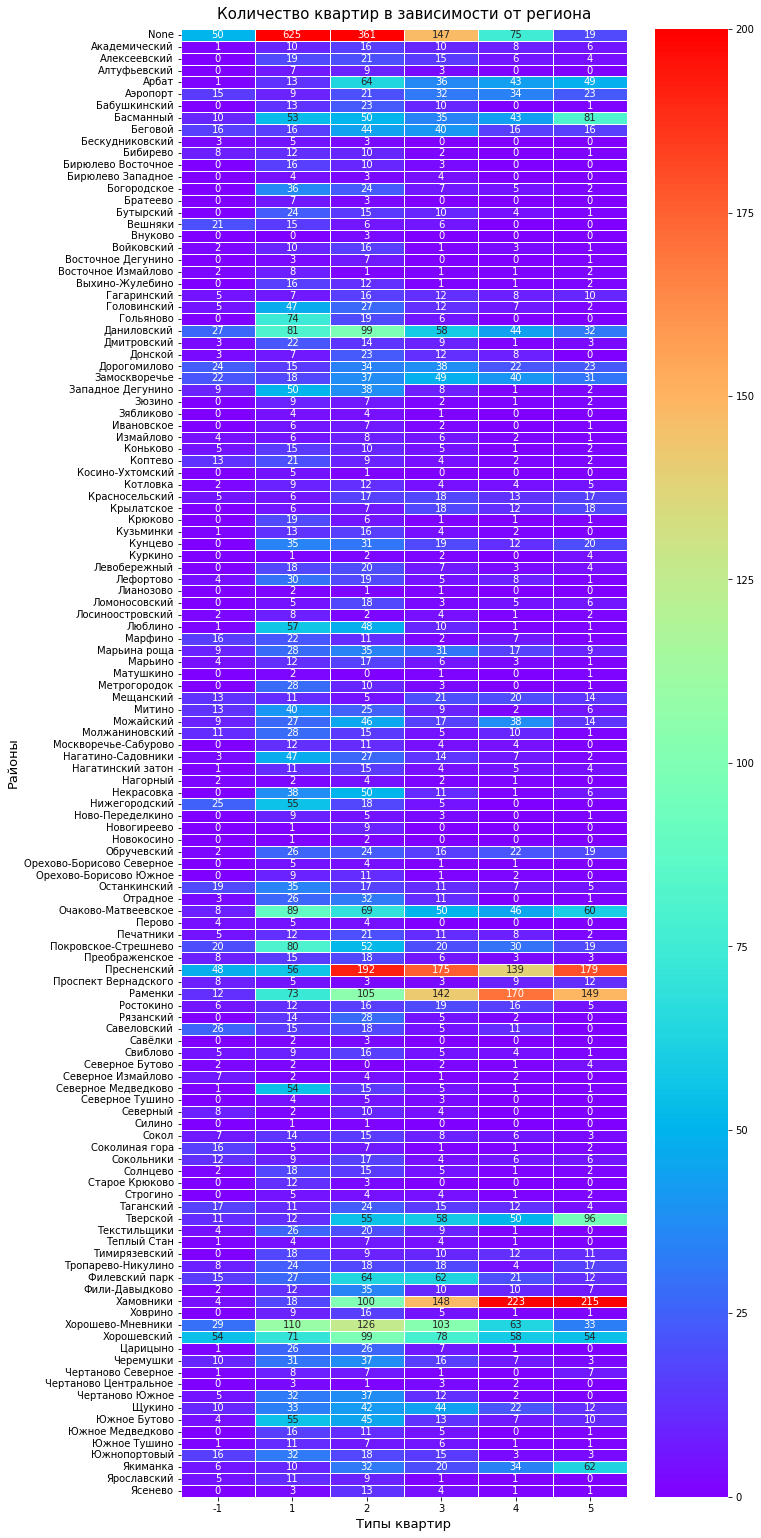

In [49]:
heatmap_data = district_rooms_count.pivot(index='district', columns='rooms_count', values='count')

plt.figure(figsize=(10, 27))

sns.heatmap(data=heatmap_data,
            cmap='rainbow',
            annot=True,
            fmt='d',
            linewidths=0.5,
            cbar=True,
            vmax=200)

plt.title('Количество квартир в зависимости от региона', fontsize=15, pad=10)
plt.xlabel('Типы квартир', fontsize=13)
plt.ylabel('Районы', fontsize=13)

plt.show()

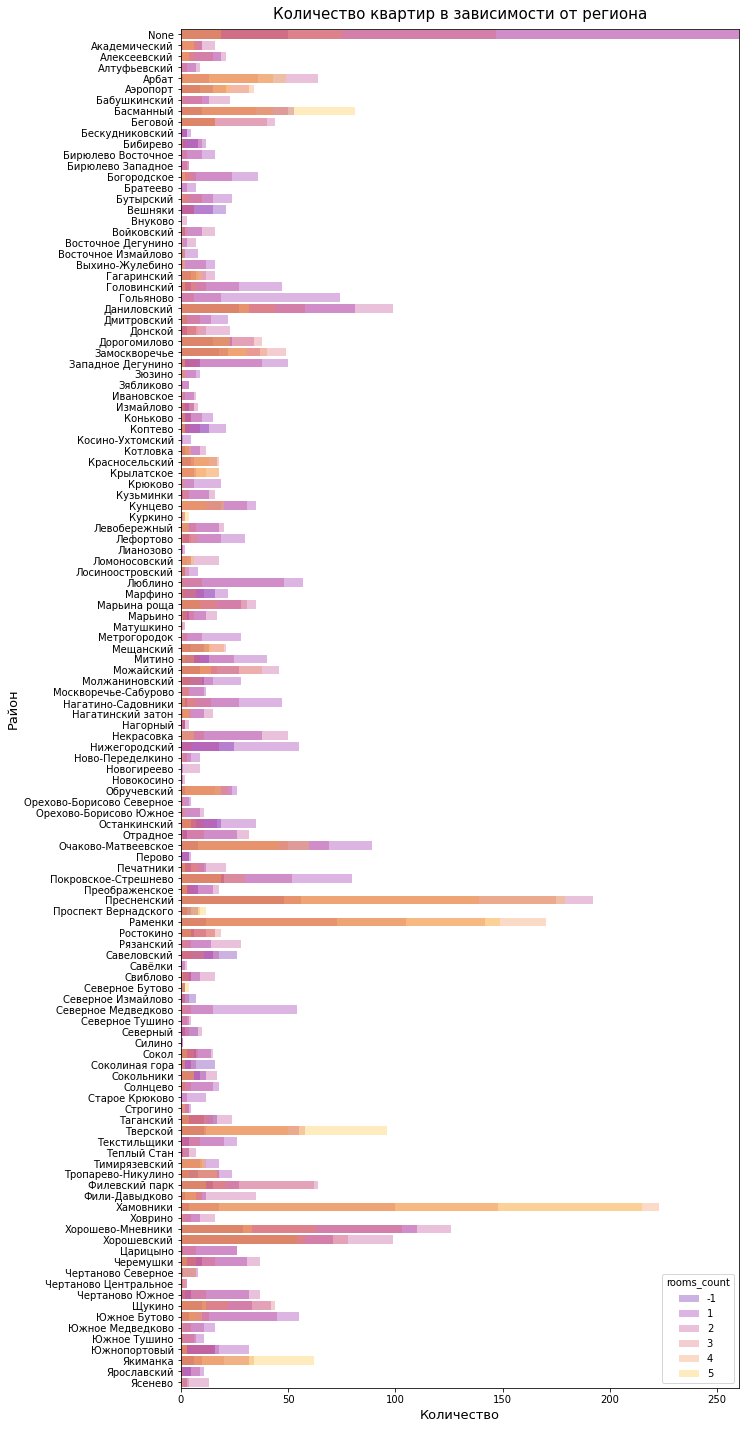

In [50]:
plt.figure(figsize=(10, 25))

ax = sns.barplot(data=district_rooms_count,
                 y='district',
                 x='count',
                 hue='rooms_count',
                 dodge=False,
                 palette='plasma',
                 alpha=0.3,
                saturation = 10) 

plt.title('Количество квартир в зависимости от региона', fontsize=15, pad=10)
plt.ylabel('Район', fontsize=13)
plt.xlabel('Количество', fontsize=13)
ax.set_xlim(0, 260)

plt.show()


- чаще всего встречаются квартиры с 1-3 комнатами

- в дорогих районах преобладают 4-5 комнатные квартиры

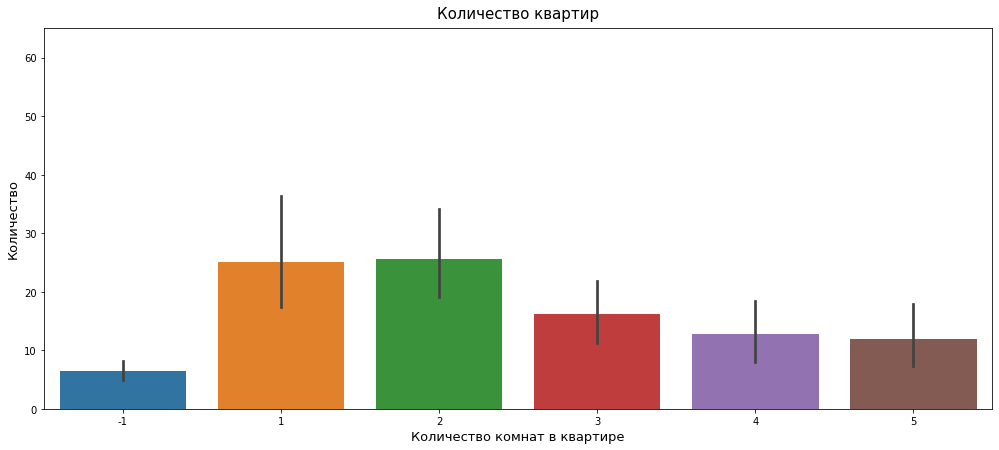

In [51]:
plt.figure(figsize=(17, 7))

ax = sns.barplot(data=district_rooms_count,
                     x='rooms_count',
                     y='count')
plt.title('Количество квартир', fontsize=15, pad=10)
plt.xlabel('Количество комнат в квартире', fontsize=13)
plt.ylabel('Количество', fontsize=13)
ax.set_ylim(0, 65)
plt.show()

- больше всего однокомнатных и духкомнатных квартир

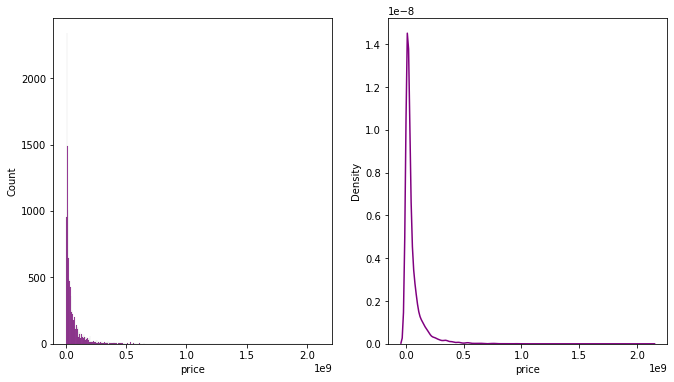

In [52]:
fgr, ax = plt.subplots(figsize=(11, 6), ncols=2)
sns.histplot(data=cian, x='price', color='purple', ax=ax[0])

sns.kdeplot(data=cian, x='price', color='purple', ax=ax[1])
plt.show()

# Построение гипотез

1. Чем больше квартира, тем дороже цена

2. Цена квартиры зависит от метро, которое ближе всего к квартире

3. Чем меньше комнат, тем дешевле цена за квадратный метр

4. Цена зависит от типа автора

5. У каждого автора есть свой ценовой диапазон

6. Средняя цена квартиры зависит от того сколько объявлений выложил автор

7. Количество продаваемых квартир больше в определённых районах

8. Цена квартиры зависит от района, в котором находится квартира

9. Цена зависит от этажности дома

10. Цена зависит от того, на каком этаже находится квартира

11. Цена зависит от того, что квартира находится на первом или последнем этаже

12. Чем меньше жилфонд, тем дороже квартира

13. Около культурных и развлекательных заведений с высокой оценкой квартиры дороже

14. В каждом округе разный диапазон цен

15. В районах с хорошей экологией квартиры дороже

16. В районах с высоким рейтингом квартиры дороже

17. Чем больше население района, тем дороже квартира

18. Есть зависимость между ценой и оценкой комфорта в данном районе

19. Цена зависит от ветки, на которой находится метро




## Проверка гипотез

In [53]:
def get_sort_barplot(data: pd.DataFrame,
                     x: str,
                     y: str,
                     ascending=False,
                     limit=None,
                     xlabel=None,
                     ylabel=None,
                     title=None):
    """
    Строит график столбчатой диаграммы с сортировкой по заданному столбцу
    """
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=x,
                     y=y,
                     data=data,
                     order=data.sort_values(y, ascending=ascending)[x][:limit])
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

### Гипотеза 1. Чем больше квартира тем дороже цена

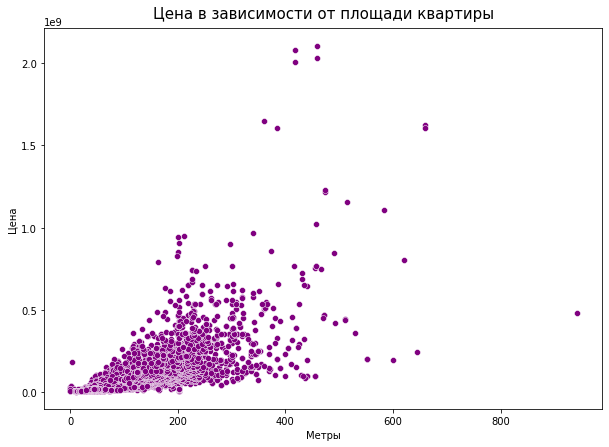

In [54]:
plt.figure(figsize=(10, 7))

ax = sns.scatterplot(x='total_meters', y='price', data=cian, color='purple')
plt.title('Цена в зависимости от площади квартиры', fontsize=15, pad=10)
plt.xlabel('Метры')
plt.ylabel('Цена')
plt.show()

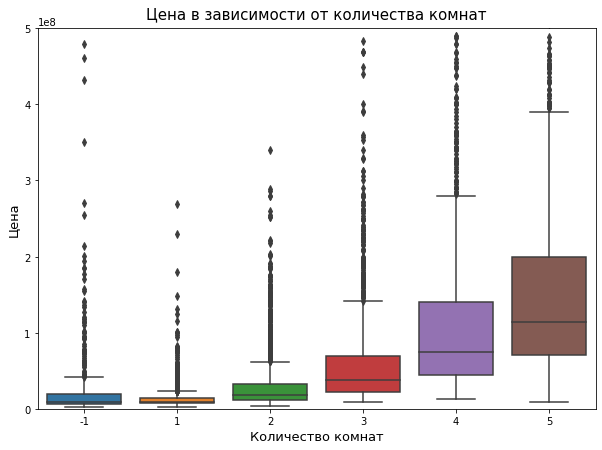

In [55]:
plt.figure(figsize=(10, 7))

ax = sns.boxplot(x='rooms_count', y='price', data=cian)
plt.title('Цена в зависимости от количества комнат', fontsize=15, pad=10)
plt.xlabel('Количество комнат', fontsize=13)
plt.ylabel('Цена', fontsize=13)
ax.set_ylim(0, 500000000)
plt.show()

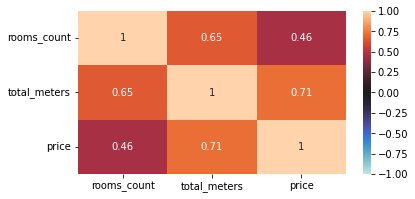

In [56]:
fig = plt.subplots(figsize=(6, 3))
sns.heatmap(cian[['rooms_count', 'total_meters', 'price']].corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center=0)
plt.show()

- размер квартиры и количество комнат напрямую связаны с ценой

### Гипотеза 2. Цена квартиры зависит от метро, которе ближе всего к квартире

In [57]:
underground_price = cian.groupby('underground')['price'].mean().reset_index()

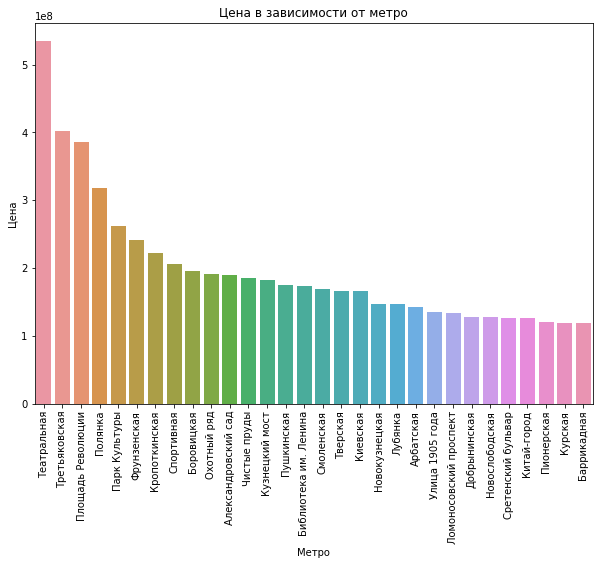

In [58]:
get_sort_barplot(data=underground_price,
                 x='underground',
                 y='price',
                 limit=30,
                 xlabel='Метро',
                 ylabel='Цена',
                 title='Цена в зависимости от метро')

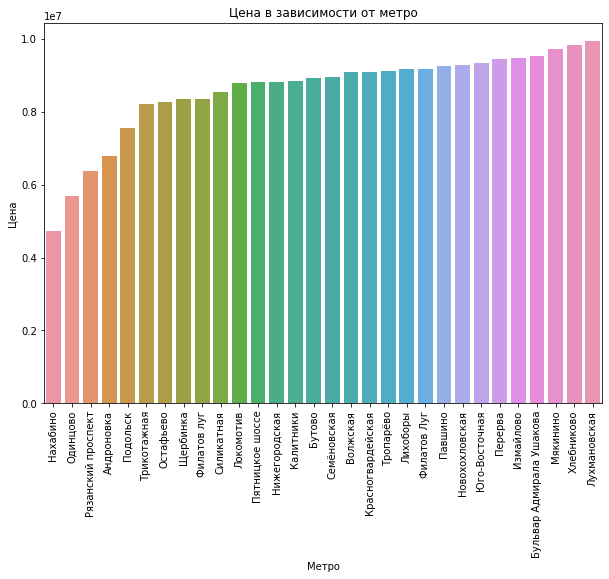

In [59]:
get_sort_barplot(data=underground_price,
                 x='underground',
                 y='price',
                 ascending=True,
                 limit=30,
                 xlabel='Метро',
                 ylabel='Цена',
                 title='Цена в зависимости от метро')

In [60]:
fig = px.box(cian, x='price', y='underground', width=800, height=600)

fig.update_layout(
    title='Распределение цен на квартиры по станциям метро',
    xaxis_title='Цена на квартиру',
    yaxis_title='Станция метро',
    font=dict(size=12),
    yaxis=dict(autorange='reversed'),
    showlegend=False,
    boxmode='group',
    boxgap=0.3, 
    boxgroupgap=0.2,  
)

fig.update_traces(
    jitter=0.5,  
    marker=dict(size=3), 
    line=dict(width=1),  
)

fig.show()

- у каждого метро свой разброс цен

- самые дорогие квартиры на метро Площадь Революции, Театральная и Третьяковская, то есть в центре

- самый дешёвые квартиры на метро Нахабино, Одинцово и Рязанский проспект

### Гипотеза 3. Чем меньше комнат, тем дешевле цена за квадратный метр


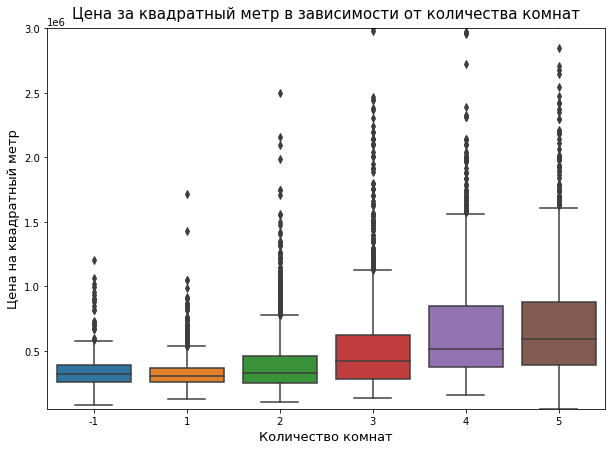

In [61]:
plt.figure(figsize=(10, 7))

ax = sns.boxplot(data=cian, x='rooms_count', y='price_per_m2')
plt.title('Цена за квадратный метр в зависимости от количества комнат', fontsize=15, pad=10)
plt.xlabel('Количество комнат', fontsize=13)
plt.ylabel('Цена на квадратный метр', fontsize=13)
ax.set_ylim(50000, 3000000)
plt.show()

- чем меньше комнат в квартире, тем дешевле квадратный метр

### Гипотеза 4. Цена зависит от типа автора


In [62]:
author_type_price = cian.groupby('author_type')['price'].mean().reset_index()

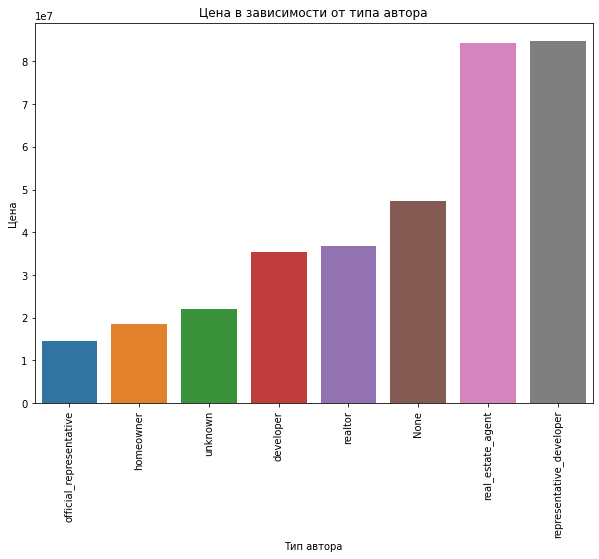

In [63]:
get_sort_barplot(data=author_type_price,
                 x='author_type',
                 y='price',
                 ascending=True,
                 limit=30,
                 xlabel='Тип автора',
                 ylabel='Цена',
                 title='Цена в зависимости от типа автора')

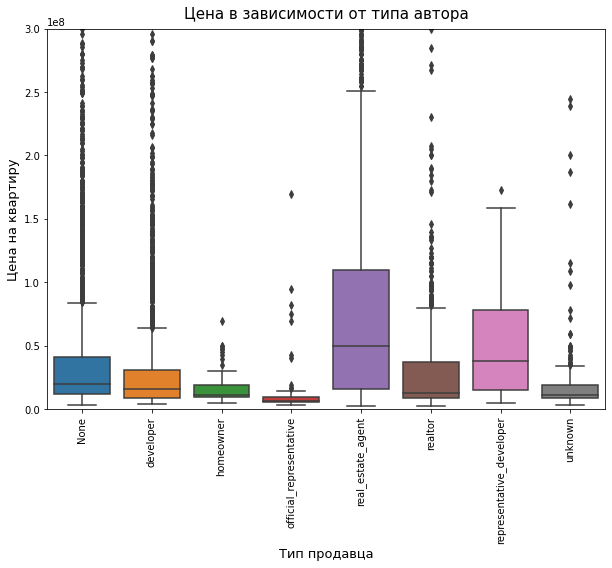

In [64]:
plt.figure(figsize=(10, 7))

ax = sns.boxplot(x='author_type', y='price', data=cian)
plt.title('Цена в зависимости от типа автора', fontsize=15, pad=10)
plt.xlabel('Тип продавца', fontsize=13)
plt.ylabel('Цена на квартиру', fontsize=13)
ax.set_ylim(0, 300000000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

- у каждого типа автора есть свой ценовой диапазон

- самая низкая цена квартиры у ук оф.представитель

- самая высокая цена квартиры у агентства недвижимости

### Гипотеза 5. У каждого автора есть свой ценновой диапазон


In [65]:
author_price = cian[cian['author_more'] == 1]

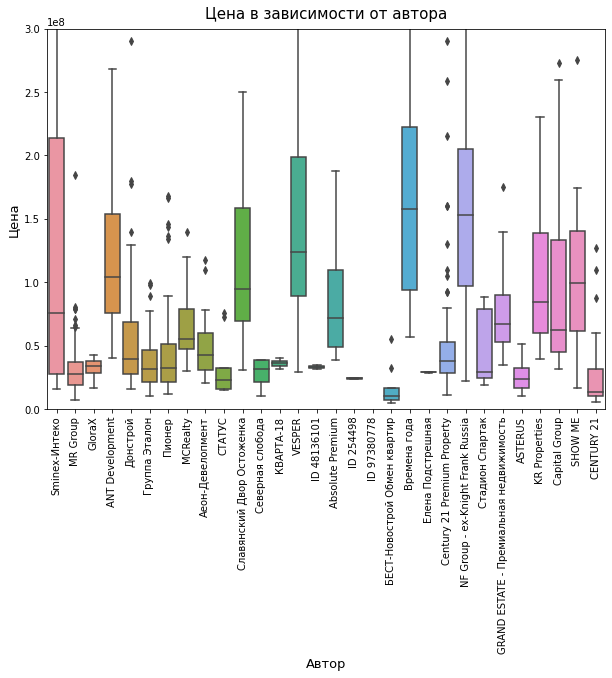

In [66]:
plt.figure(figsize=(10, 7))

ax = sns.boxplot(data=author_price,
                 x='author',
                 y='price',
                 order=cian['author'].unique()[:30])
plt.title('Цена в зависимости от автора', fontsize=15, pad=10)
plt.xlabel('Автор', fontsize=13)
plt.ylabel('Цена', fontsize=13)
ax.set_ylim(0, 300000000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [67]:
fig = px.box(cian, x='price', y='author', width=800, height=600)

fig.update_layout(
    title='Цена в зависимости от типа автора',
    xaxis_title='Цена на квартиру',
    yaxis_title='Автор',
    font=dict(size=12),
    yaxis=dict(autorange='reversed'),
    showlegend=False,
    boxmode='group',
    boxgap=0.3, 
    boxgroupgap=0.2,  
)

fig.update_traces(
    jitter=0.5,  
    marker=dict(size=3), 
    line=dict(width=1),  
)

fig.show()

- у каждого автора свой диапазон

- ценовой диапазон у авторов могут разниться, потому что они продают квартиры в определённых районах

### Гипотеза 6. Средняя ценя квартиры зависит от того сколько объявлений выложил автор


In [68]:
author_count_price = cian.groupby('author_count')['price'].mean().reset_index()

In [69]:
def get_sort_barplot(data, x, y, ascending=True, limit=None, xlabel=None, ylabel=None, title=None):
    """Сортировка данных по оси X"""
    sorted_data = data.sort_values(by=x, ascending=ascending)
    
    if limit:
        sorted_data = sorted_data.head(limit)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=sorted_data, x=x, y=y, ax=ax)
    
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=15, pad=10)
    
    plt.show()

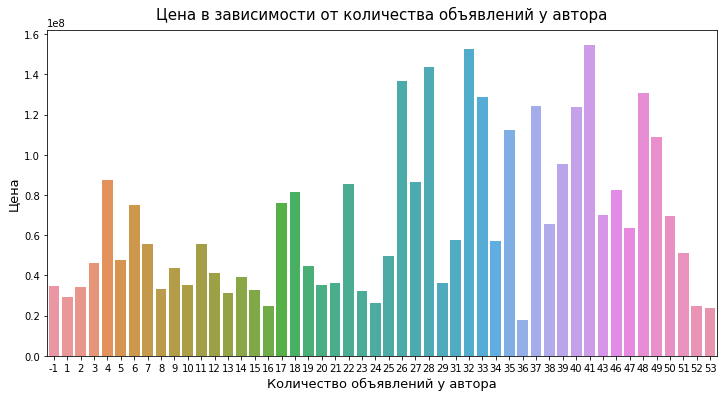

In [70]:
get_sort_barplot(data=author_count_price,
                 x='author_count',
                 y='price',
                 ascending=True,
                 limit=50,
                 xlabel='Количество объявлений у автора',
                 ylabel='Цена',
                 title='Цена в зависимости от количества объявлений у автора')

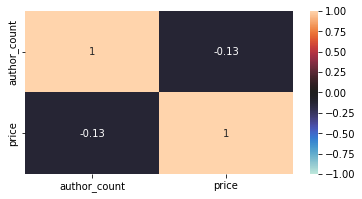

In [71]:
fig = plt.subplots(figsize=(6, 3))

sns.heatmap(cian[['author_count', 'price']].corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center=0)
plt.show()

- количество объявлений никак не влияет на цену

### Гипотеза 7. Количество продаваемых квартир больше в определёных районах


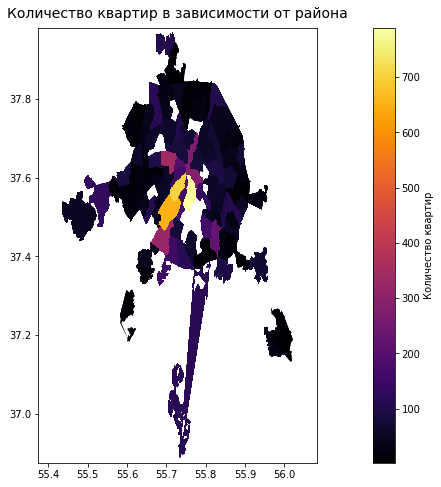

In [72]:
fig, ax = plt.subplots(figsize=(20, 8))  

colors = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

geo_gpd.plot(ax=ax,
             column='link',
             linewidth=1,
             cmap=colors[2],
             legend=True,
             legend_kwds={
                 'label': 'Количество квартир',
                 'orientation': 'vertical'
             })

ax.set_aspect('equal')
plt.title('Количество квартир в зависимости от района', fontsize=14, pad=10)

widen_plot(ax, x_scale_factor=1.1, y_scale_factor = 0.93)

plt.show()

- Чем ближе к центру, тем больше квартир там продаётся

### Гипотеза 8. Цена квартиры зависит от района, в котором находится квартира


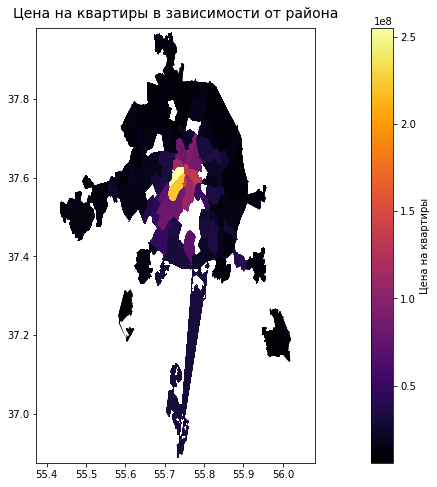

In [73]:
fig, ax = plt.subplots(figsize=(20, 8)) 

geo_gpd.plot(ax=ax,
             column='price',
             linewidth=1,
             cmap=colors[2],
             legend=True,
             legend_kwds={
                 'label': 'Цена на квартиры',
                 'orientation': 'vertical'
             })

ax.set_aspect('equal')
plt.title('Цена на квартиры в зависимости от района', fontsize=14, pad=10)

widen_plot(ax, x_scale_factor=1.1, y_scale_factor = 0.93)

plt.show()

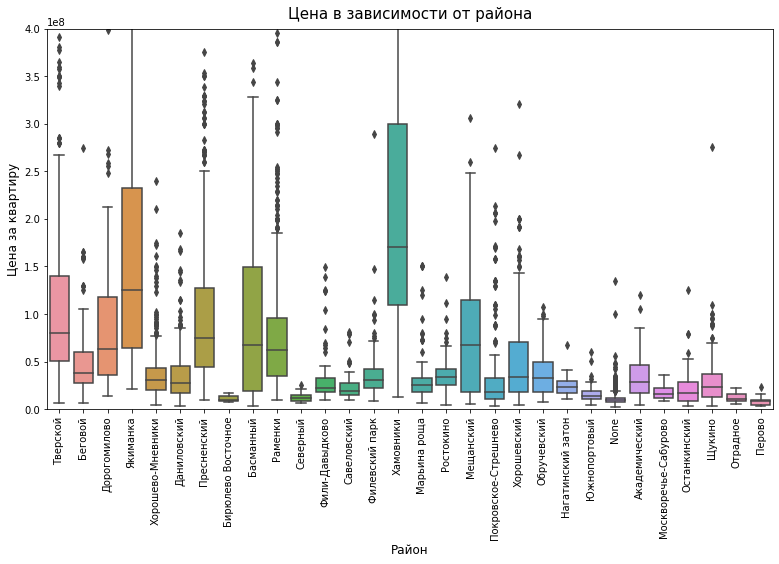

In [74]:
plt.figure(figsize=(13, 7))

ax = sns.boxplot(data=cian,
                 x='district',
                 y='price',
                 order=cian['district'].unique()[:30])
plt.title('Цена в зависимости от района', fontsize=15, pad=10)
plt.xlabel('Район', fontsize=12)
plt.ylabel('Цена за квартиру', fontsize=12)
ax.set_ylim(0, 400000000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

- в центре квартиры дороже всего

### Гипотеза 9. Цена зависит от этажности дома


Дома разделаются в зависимости от количества этажей на категории:

1 - малоэтажные (1 - 2 этажа)

2 - средней этажности (3 - 5 этажей)

3 - многоэтажные (6-10)

4 - повышенной этажности (11 - 16 этажей)

5 - высотные (16-50 этажей)

6 - очень высотные (более 50 этажей)


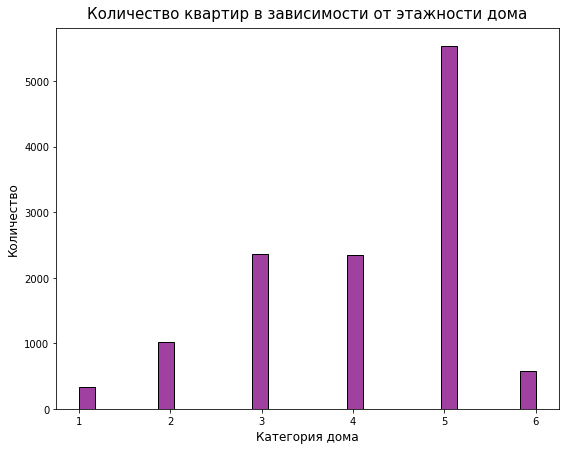

In [75]:
plt.figure(figsize=(9, 7))

sns.histplot(data=cian, x='house_category', color='purple')
plt.title('Количество квартир в зависимости от этажности дома', fontsize=15, pad=10)
plt.xlabel('Категория дома', fontsize=12)
plt.ylabel('Количество', fontsize=12)


plt.show()

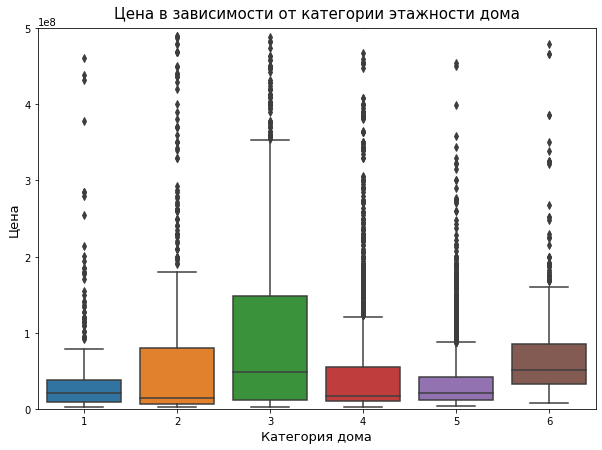

In [76]:
plt.figure(figsize=(10, 7))

ax = sns.boxplot(data=cian, x='house_category', y='price')
plt.title('Цена в зависимости от категории этажности дома', fontsize=15, pad=10)
plt.xlabel('Категория дома', fontsize=13)
plt.ylabel('Цена', fontsize=13)
ax.set_ylim(0, 500000000)

plt.show()

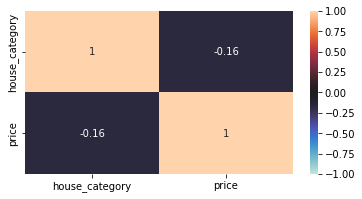

In [77]:
fig = plt.subplots(figsize=(6, 3))

sns.heatmap(cian[['house_category', 'price']].corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center=0)

plt.show()

- самые дорогие квартиры в домах, в которых 6-10 этажей

- в очень высотных домах квартиры по цене находятся на втором месте. В таких домах начальная цена квартир самая дорогая

- в остальных домах средняя цена примерно одинакова, различие только в разбросе цен, возможно она связана с тем на каком этаже находится квартира

- больше всего квартир в домах от 16 до 40 этажей, возможно в связи экономии места


### Гипотеза 10. Цена зависит от того на каком этаже находится квартира


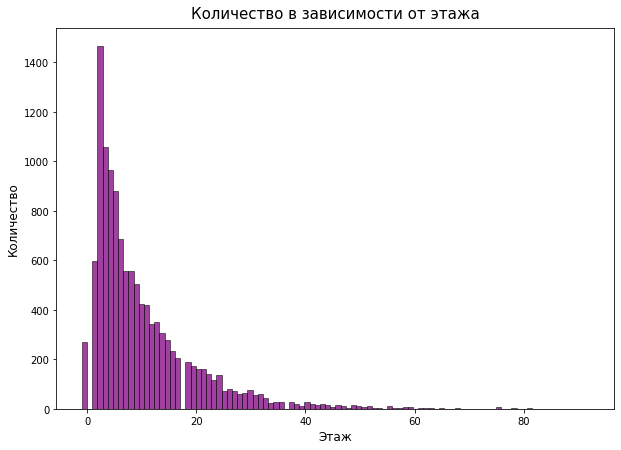

In [78]:
plt.figure(figsize=(10, 7))

sns.histplot(data=cian, x='floor', color='purple')
plt.title('Количество в зависимости от этажа', fontsize=15, pad=10)
plt.xlabel('Этаж', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.show()

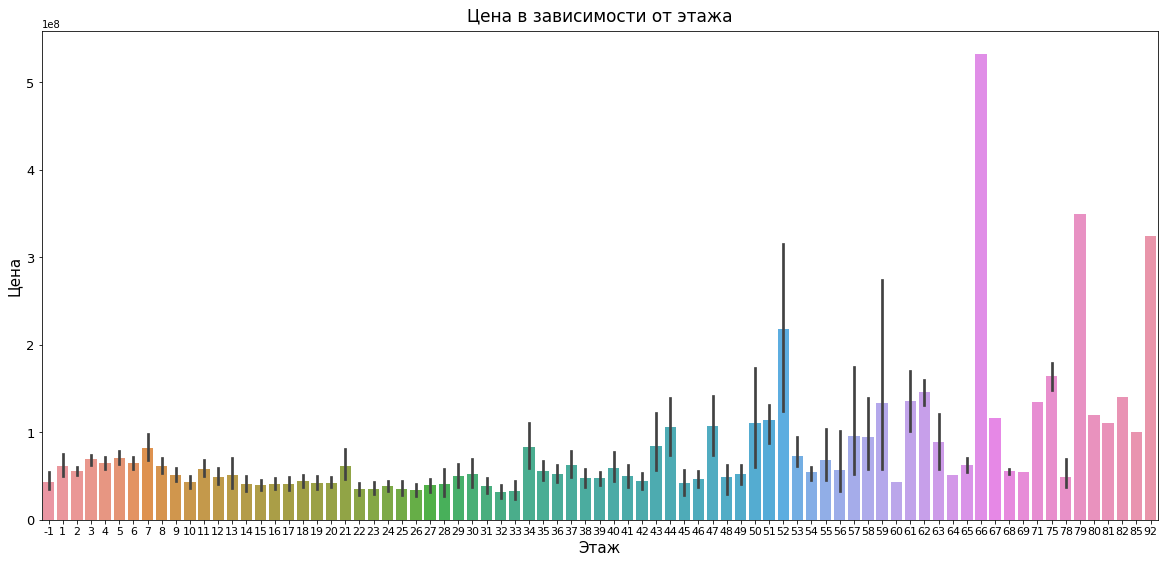

In [79]:
plt.figure(figsize=(20, 9))

ax = sns.barplot(data=cian, x='floor', y='price')
plt.title('Цена в зависимости от этажа', fontsize=17,pad=10)
plt.xlabel('Этаж', fontsize=15)
plt.ylabel('Цена', fontsize=15)

ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=13)

plt.show()

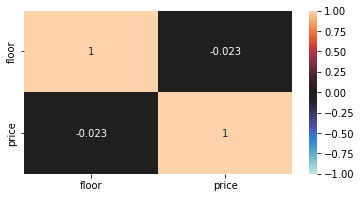

In [80]:
fig = plt.subplots(figsize=(6, 3))

sns.heatmap(cian[['floor', 'price']].corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center=0)
plt.show()

- чем ниже этаж, тем больше количество квартир

- квартиры на очень высоких этажах встречаются редко, возможно поэтому цена на них дороже

- в среднем самые дорогие квартиры на 7 этаже

- в среднем самые дешёвые квартиры на 32 этаже, возможно это связано с тем, что это последний этаж в некоторых домах

- в высоких домах (скорее всего новостройки) до 40 этажей, чем выше этаж, тем ниже цена. Возможно, это связано с тем что людям некомфортно жить так высоко

### Гипотеза 11. Цена зависит от того, что квартира находится на первом или последнем этаже



0 - середина,

1 -первый этаж,

2 - последний этаж


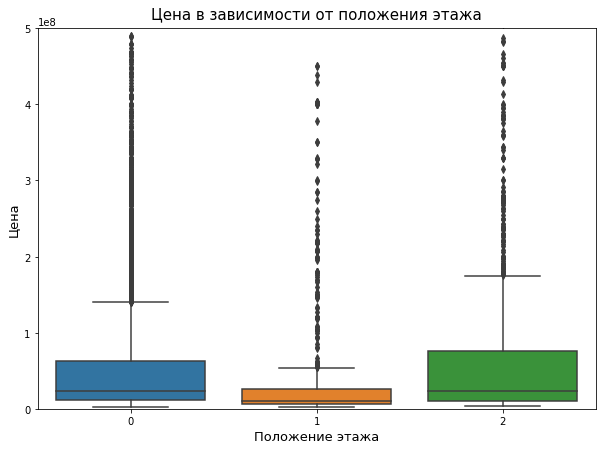

In [81]:
plt.figure(figsize=(10, 7))

ax = sns.boxplot(data=cian, x='floor_position', y='price')
plt.title('Цена в зависимости от положения этажа', fontsize=15, pad=10)
plt.xlabel('Положение этажа', fontsize=13)
plt.ylabel('Цена', fontsize=13)
ax.set_ylim(0, 500000000)
plt.show()

- квартиры на первом этаже самые дешёвые

- средняя цена квартир на последнем этаже примерно такая же, как и на других этажах, но имеется хвост в сторону увеличения цены, т к в некоторых домах последний этаж это пентхаус

- за счёт того, что обычные квартиры на последнем этаже меньше ценятся, начальная цена меньше чем на других этажах

### Гипотеза 12. Чем меньше жилфонд, тем дороже квартира


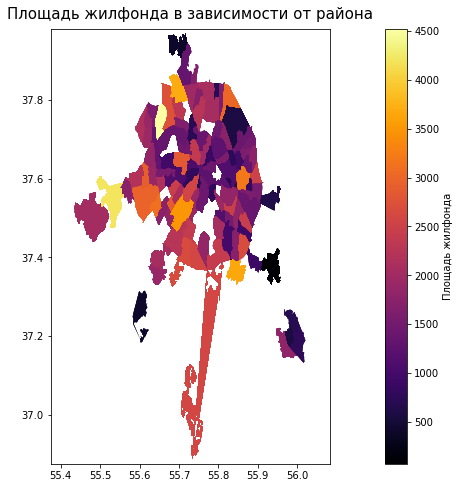

In [82]:
fig, ax = plt.subplots(figsize=(20, 8)) 

geo_gpd.plot(ax=ax,
             column='housing_fund_area',
             linewidth=1,
             cmap=colors[2],
             legend=True,
             legend_kwds={
                 'label': 'Площадь жилфонда',
                 'orientation': 'vertical'
             })

ax.set_aspect('equal')
plt.title('Площадь жилфонда в зависимости от района', fontsize=15, pad=10)

widen_plot(ax, x_scale_factor=1.1, y_scale_factor = 0.93)

plt.show()

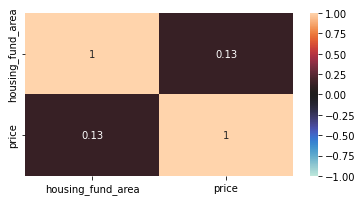

In [83]:
fig = plt.subplots(figsize=(6, 3))

sns.heatmap(cian[['housing_fund_area', 'price']].corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center=0)

plt.show()

- площадь жилфонда и цена квартиры никак не связаны

### Гипотеза 13. Около культурных и развлекательных заведений с высокой оценкой квартиры дороже


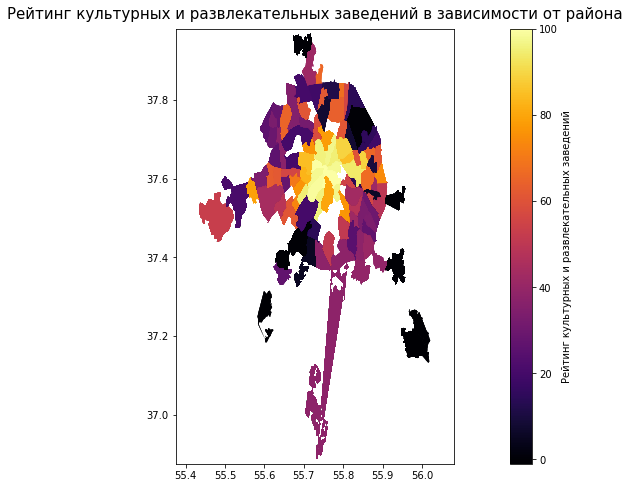

In [84]:
fig, ax = plt.subplots(figsize=(20, 8))

geo_gpd.plot(ax=ax,
             column='entertainment_infrastructure_rating',
             linewidth=1,
             cmap=colors[2],
             legend=True,
             legend_kwds={
                 'label': 'Рейтинг культурных и развлекательных заведений',
                 'orientation': 'vertical'
             })

ax.set_aspect('equal')
plt.title('Рейтинг культурных и развлекательных заведений в зависимости от района', fontsize=15, pad=10)

widen_plot(ax, x_scale_factor=1.1, y_scale_factor = 0.93)

plt.show()

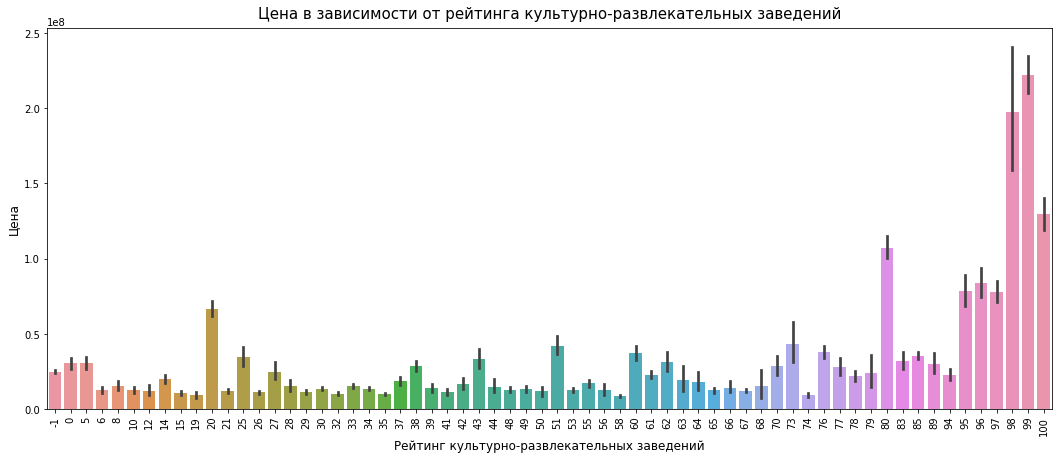

In [85]:
plt.figure(figsize=(18, 7))

ax = sns.barplot(x='entertainment_infrastructure_rating', y='price', data=cian)
plt.title('Цена в зависимости от рейтинга культурно-развлекательных заведений',
          fontsize=15,
          pad=10)
plt.xlabel('Рейтинг культурно-развлекательных заведений', fontsize=12)
plt.ylabel('Цена', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

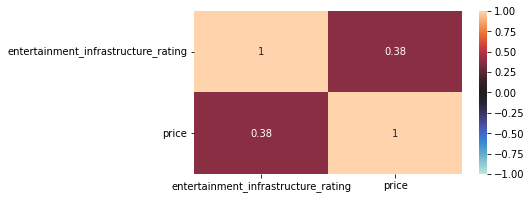

In [86]:
fig = plt.subplots(figsize=(6, 3))
sns.heatmap(cian[['entertainment_infrastructure_rating', 'price']].corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center=0)
plt.show()

- чем ближе к центру, тем больше рейтинг у заведений
- цена скорее зависит не от рейтинга заведений вокруг, сколько от района

### Гипотеза 14. В каждом округе разный диапазон цен


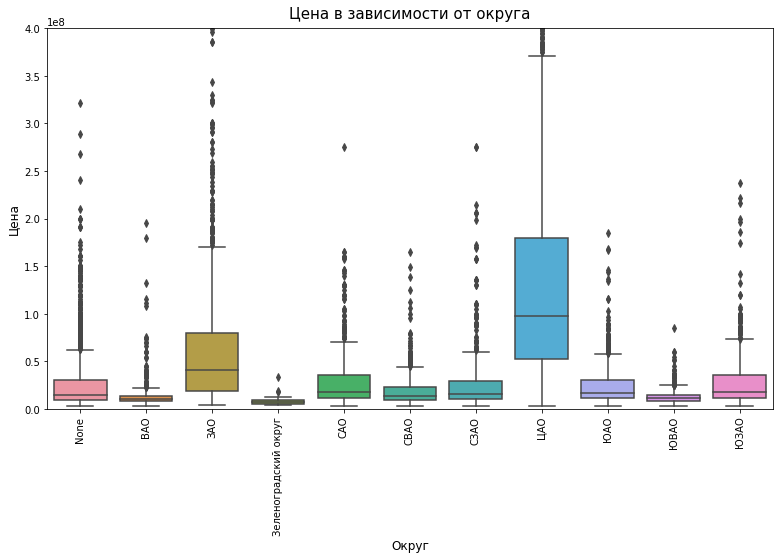

In [87]:
plt.figure(figsize=(13, 7))

ax = sns.boxplot(data=cian, x='area', y='price')
plt.title('Цена в зависимости от округа', fontsize=15, pad=10)
plt.xlabel('Округ', fontsize=12)
plt.ylabel('Цена', fontsize=12)
ax.set_ylim(0, 400000000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

- дешевле всего квартиры на востоке Москвы и Зеленоградском округе
- дороже всего квартиры в ЦАО, ЗАО 

### Гипотеза 15. В районах с хорошей экологией квартиры дороже


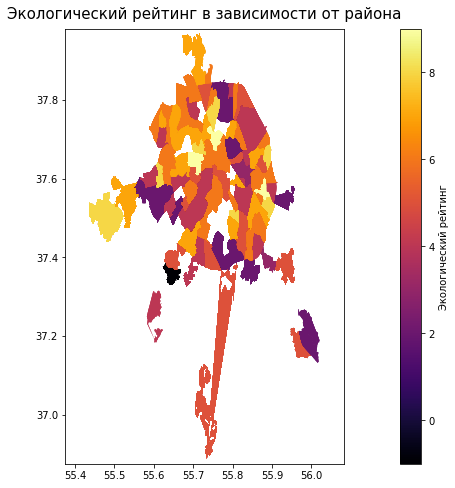

In [88]:
fig, ax = plt.subplots(figsize=(20, 8))

geo_gpd.plot(ax=ax,
             column='eco_rating',
             linewidth=1,
             cmap=colors[2],
             legend=True,
             legend_kwds={
                 'label': 'Экологический рейтинг',
                 'orientation': 'vertical'
             })

ax.set_aspect('equal')
plt.title('Экологический рейтинг в зависимости от района', fontsize=15, pad=10)

widen_plot(ax, x_scale_factor=1.1, y_scale_factor = 0.93)

plt.show()

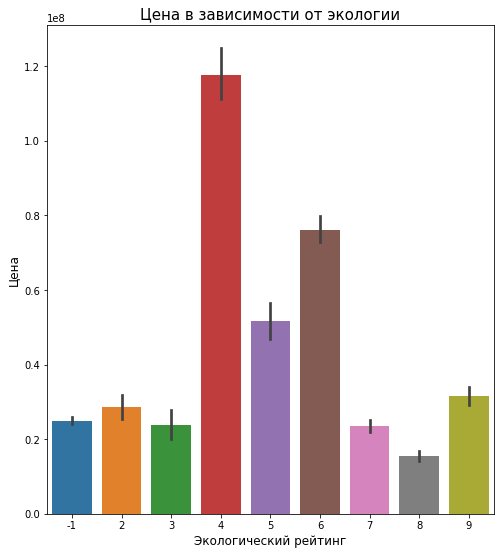

In [89]:
plt.figure(figsize=(8, 9))

sns.barplot(data=cian,
            x='eco_rating',
            y='price',
            order=sorted(cian['eco_rating'].unique()))
plt.title('Цена в зависимости от экологии', fontsize=15)
plt.xlabel('Экологический рейтинг', fontsize=12)
plt.ylabel('Цена', fontsize=12)

plt.show()

- экология мало влияет на цену квартиры

### Гипотеза 16. В районах с высоким рейтингом квартиры дороже


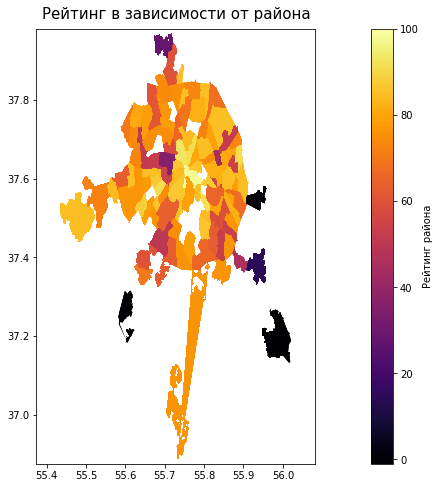

In [90]:
fig, ax = plt.subplots(figsize=(20, 8)) 

geo_gpd.plot(ax=ax,
             column='residential_infrastructure_rating',
             linewidth=1,
             cmap=colors[2],
             legend=True,
             legend_kwds={
                 'label': 'Рейтинг района',
                 'orientation': 'vertical'
             })

ax.set_aspect('equal')
plt.title('Рейтинг в зависимости от района', fontsize=15, pad=10)

widen_plot(ax, x_scale_factor=1.1, y_scale_factor = 0.93)

plt.show()

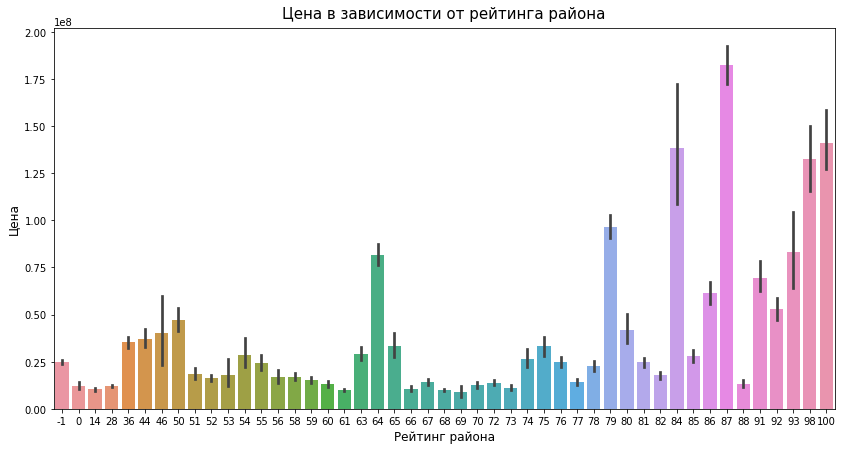

In [91]:
plt.figure(figsize=(14, 7))

sns.barplot(data=cian, x='residential_infrastructure_rating', y='price')
plt.title('Цена в зависимости от рейтинга района', fontsize=15, pad=10)
plt.xlabel('Рейтинг района', fontsize=12)
plt.ylabel('Цена', fontsize=12)

plt.show()

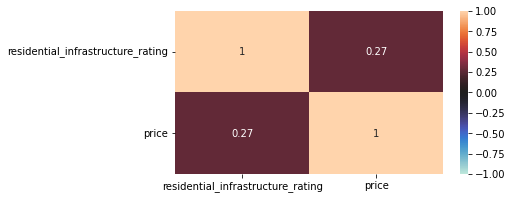

In [92]:
fig = plt.subplots(figsize=(6, 3))
sns.heatmap(cian[['residential_infrastructure_rating', 'price']].corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center=0)
plt.show()

- рейтинг района влияет на цену только в совокупности с другими признаками

### Гипотеза 17. Чем больше плотность население района, тем дороже квартира

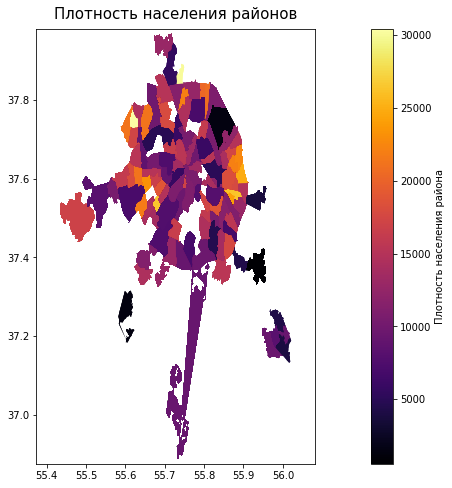

In [93]:
fig, ax = plt.subplots(figsize=(20, 8))

geo_gpd.plot(ax=ax,
             column='population_density',
             linewidth=1,
             cmap=colors[2],
             legend=True,
             legend_kwds={
                 'label': 'Плотность населения района',
                 'orientation': 'vertical'
             })

ax.set_aspect('equal')
plt.title('Плотность населения районов', fontsize=15, pad = 10)

widen_plot(ax, x_scale_factor=1.1, y_scale_factor = 0.93)

plt.show()

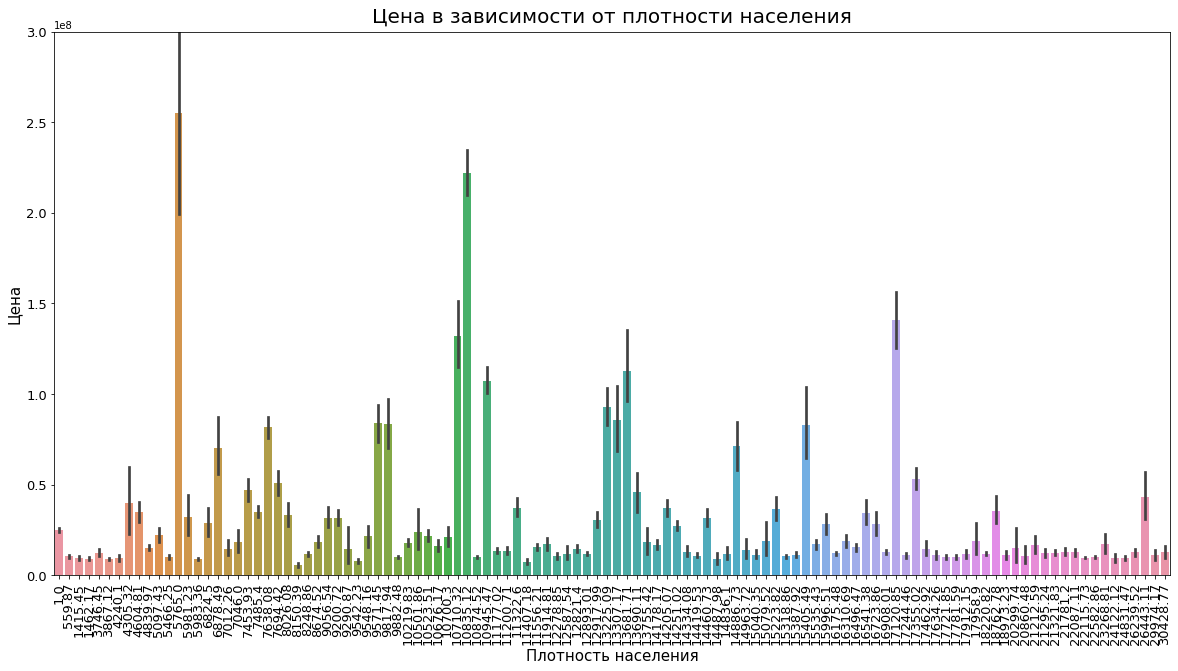

In [94]:
plt.figure(figsize=(20, 10))

ax = sns.barplot(data=cian, x='population_density', y='price')

plt.title('Цена в зависимости от плотности населения', fontsize=20,  pad = 10)
plt.xlabel('Плотность населения',  fontsize=15)
plt.ylabel('Цена', fontsize=15)
ax.set_ylim(0, 300000000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)
ax.tick_params(axis='y', labelsize=13)

plt.show()

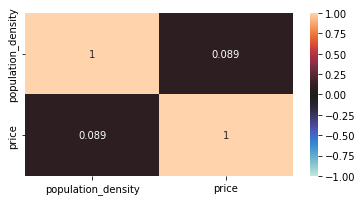

In [95]:
fig = plt.subplots(figsize=(6, 3))

sns.heatmap(cian[['population_density', 'price']].corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center=0)
plt.show()

- зависимости между ценой и плотностью населения нет

### Гипотеза 18. Есть зависимость между ценой и оценкой комфорта в данном районе

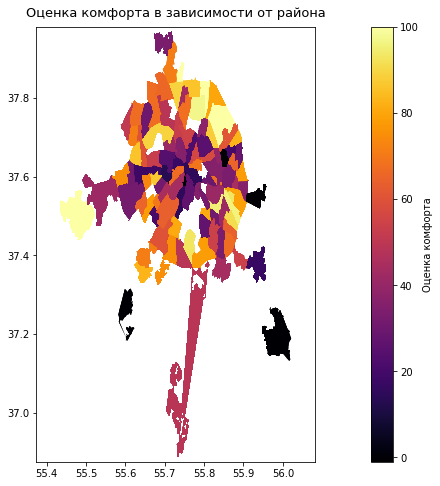

In [96]:
fig, ax = plt.subplots(figsize=(20, 8))

geo_gpd.plot(ax=ax,
             column='convenient_for_life',
             linewidth=1,
             cmap=colors[2],
             legend=True,
             legend_kwds={
                 'label': 'Оценка комфорта',
                 'orientation': 'vertical'
             })

ax.set_aspect('equal')
plt.title('Оценка комфорта в зависимости от района', fontsize=13, pad = 10)

widen_plot(ax, x_scale_factor=1.1, y_scale_factor = 0.93)

plt.show()

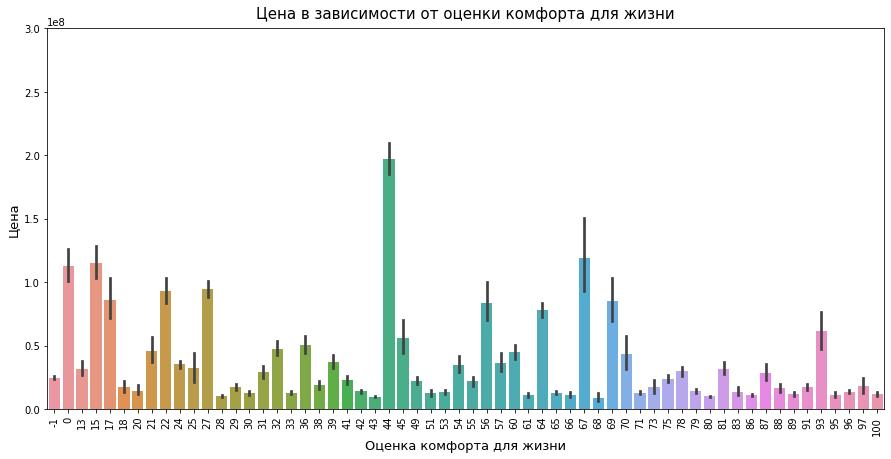

In [97]:
plt.figure(figsize=(15, 7))

ax = sns.barplot(data=cian, x='convenient_for_life', y='price')
plt.title('Цена в зависимости от оценки комфорта для жизни', fontsize=15,  pad = 10)
plt.xlabel('Оценка комфорта для жизни', fontsize=13)
plt.ylabel('Цена', fontsize=13)
ax.set_ylim(0, 300000000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

geo_gpd.plot(ax=ax,
             column='very_convenient_for_life',
             linewidth=1,
             cmap=colors[2],
             legend=True,
             figsize=[8, 8],
             legend_kwds={
                 'label': 'Оценка "очень комфортно" для жизни',
                 'orientation': 'vertical'
             })

ax.set_aspect('equal')
plt.title('Оценка "очень комфортно" для жизни в зависимости от района', fontsize=15, pad = 10)

ax.set_aspect('equal')

widen_plot(ax, x_scale_factor=1.1, y_scale_factor = 0.93)

plt.show()

In [ ]:
plt.figure(figsize=(15, 7))

ax = sns.barplot(data=cian, x='very_convenient_for_life', y='price')
plt.title('Цена в зависимости от оценки очень комфортно для жизни', fontsize=15)
plt.xlabel('Оценка очень комфортно для жизни', fontsize=10)
plt.ylabel('Цена', fontsize=10)
ax.set_ylim(0, 300000000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
fig = plt.subplots(figsize=(6, 3))

sns.heatmap(cian[['very_convenient_for_life', 'convenient_for_life',
                  'price']].corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center=0)
plt.show()


- критерий "очень комфортно для жизни" больше коррелирует с ценой, чем "комфортно для жизни"

### Гипотеза 19. Цена зависит от ветки, на котрой находится метро

In [ ]:
plt.figure(figsize=(17, 7))

ax = sns.boxplot(data=cian, x='line', y='price')
plt.title('Цена в зависомости от линии метро', fontsize=15, pad = 10)
plt.xlabel('Линия метро', fontsize=12)
plt.ylabel('Цена', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(0, 1000000000)
plt.show()

- линия метро влияет на цену квартиры

- на Кольцевой линии самый большой порог цены и самая высокая средняя цена

- на Калининской линии самый большой разброс цен, потому что она идёт от центра до края Москвы

- самая дешёвые квартиры на Некрасовской линии

# Выводы

- размер квартиры и количество комнат напрямую связаны с ценой

- цена квартиры зависит от метро

- у каждого метро свой разброс цен

- чем меньше комнат в квартире, тем дешевле квадратный метр

- у каждого типа автора есть свой ценовой диапазон

- самая низкая цена квартиры у ук оф.представитель

- самая высокая цена квартиры у агентства недвижимости

- чем ближе к центру, тем больше квартир там продаётся, потому что мало людей, которые могут себе позволить их купить

- в центре квартиры дороже всего

- самые дорогие квартиры в домах, в которых 6-10 этажей

- больше всего квартир в домах от 16 до 40 этажей, возможно в связи экономии места

- чем ниже этаж, тем больше количество квартир

- в среднем самые дорогие квартиры на 7 этаже

- в высоких домах (скорее всего новостройки) до 40 этажей, чем выше этаж, тем ниже цена. Возможно, это связано с тем что людям некомфортно жить так высоко

- квартиры на первом этаже самые дешёвые

- средняя цена квартир на последнем этаже примерно такая же, как и на других этажах, но имеется хвост в сторону увеличения цены, т к в некоторых домах последний этаж это пентхаус

- чем ближе к центру, тем больше рейтинг у культурно-развлекательных заведений

- дешевле всего квартиры на востоке Москвы и Зеленоградском округе

- дороже всего квартиры в ЦАО, ЗАО 

- экология мало влияет на цену квартиры

- критерий "очень комфортно для жизни" больше коррелирует с ценой, чем "комфортно для жизни"

- на Кольцевой линии самый большой порог цены

- на Калининской линии самая высокая средняя цена и самый большой разброс цен

- самая дешёвые квартиры на Некрасовской линии


In [ ]:
#cian.to_csv('cian.csv', index=False)

полученный файл поместить в папку data